## Dataset exploration and cleaning

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from tqdm.auto import tqdm


In [2]:
df = pd.read_csv('WELFake_Dataset.tsv', sep = '\t')
df.head(2)

id                                              title  \
0   0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1   2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...    1.0  
1   Now, most of the demonstrators gathered last ...    1.0

In [3]:
df['full_text'] = df['title'] + ' ' + df['text']
df.head(2)

id                                              title  \
0   0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1   2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   

                                                text  label  \
0  No comment is expected from Barack Obama Membe...    1.0   
1   Now, most of the demonstrators gathered last ...    1.0   

                                           full_text  
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...  
1  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_news_distribution(df):

	news_counts = df['label'].value_counts().reset_index()
	news_counts.columns = ['label', 'count']
	news_counts['label'] = news_counts['label'].map({0.0: 'True', 1.0: 'Fake'})
	news_counts['percentage'] = (news_counts['count'] / news_counts['count'].sum() * 100).round(1)
	
	# Create the bar plot
	fig, ax = plt.subplots(figsize=(6, 5))
	sns.barplot(
		data=news_counts,
		x='label',
		y='count',
		hue='label', 
		palette=['#2ecc71', '#e74c3c'],
		legend=False,
		ax=ax
	)
	
	ax.set_title('Distribution of True vs. Fake News Articles', 
			  fontsize=10, 
			  pad=20,
			  fontweight='bold')
	ax.set_xlabel('News Classification', fontsize=12, labelpad=10)
	ax.set_ylabel('Number of Articles', fontsize=12, labelpad=10)
	
	for i, bar in enumerate(ax.patches):
		count = news_counts.iloc[i]['count']
		percentage = news_counts.iloc[i]['percentage']
		ax.text(
			bar.get_x() + bar.get_width() / 2,
			bar.get_height(),
			f'{int(count):,}\n({percentage}%)',
			ha='center',
			va='bottom',
			fontsize=10
		)
	
	ax.grid(axis='y', linestyle='--', alpha=0.5)
	sns.despine()
	
	# Adjust layout to prevent label cutoff
	plt.tight_layout()

	plt.savefig('news_distribution.png',
					   bbox_inches='tight',
					   dpi=300)
	
	# Display the plot
	plt.show()

	for _, row in news_counts.iterrows():
		print(f"{row['label']} News: {row['count']/len(df):.2f}")


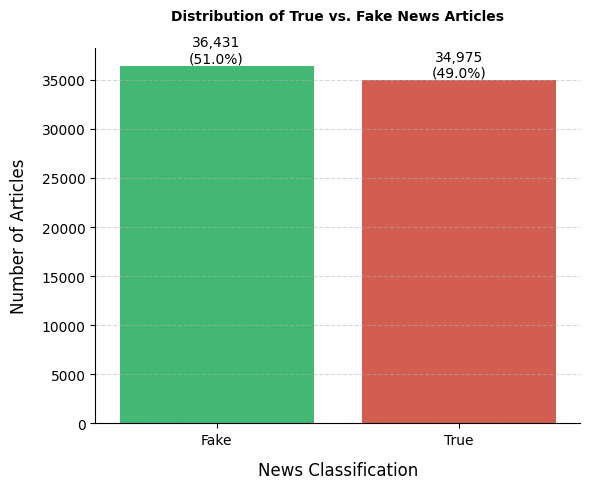

Fake News: 0.51
True News: 0.49


In [5]:
plot_news_distribution(df)

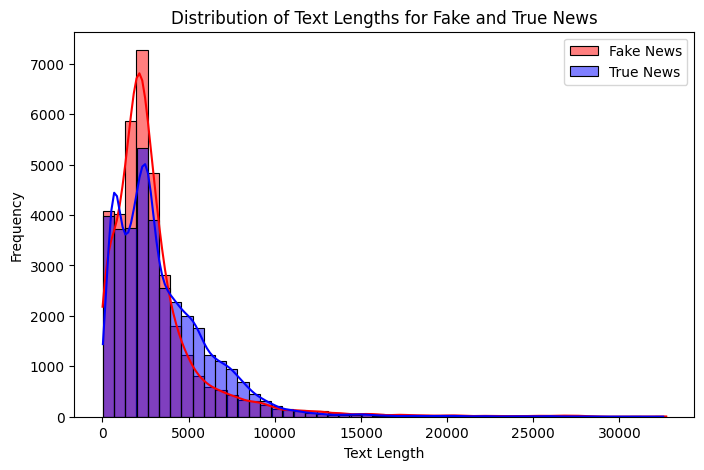

In [6]:
# Plot the distribution of text lengths for fake and true news
plt.figure(figsize=(8, 5))
sns.histplot(data=df[df['label'] == 1.0]['full_text'].str.len(), color='red', label='Fake News', kde=True, bins=50)
sns.histplot(data=df[df['label'] == 0.0]['full_text'].str.len(), color='blue', label='True News', kde=True, bins=50)
plt.title('Distribution of Text Lengths for Fake and True News')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Check and drop duplicate and non english news

In [7]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from tqdm import tqdm
import pandas as pd

# Enable progress bar for Pandas apply
tqdm.pandas()

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return None

# Detect language for each article with progress bar
languages = df['text'].progress_apply(detect_language)


100%|██████████| 71406/71406 [15:36<00:00, 76.25it/s] 


In [8]:
languages_count = languages.value_counts().reset_index()
languages_count.columns = ['Language', 'Count']
languages_count = languages_count.sort_values(by='Count', ascending=False)

non_english_count = (languages != 'en').sum()
print(f"Number of non-English news articles: {non_english_count}")

print("Detected Languages (sorted by count):")
print(languages_count.to_string(index=False))

Number of non-English news articles: 1355
Detected Languages (sorted by count):
Language  Count
      en  70051
      ru    155
      es    146
      de    108
      fr     40
      ar     19
      sw     12
      pt     10
      tr      7
      pl      4
      no      4
      it      4
      nl      3
      hr      2
      af      2
      el      2
      fi      2
      vi      1
      so      1
      ro      1
   zh-cn      1
      tl      1


In [9]:
# Filter out non-English news articles
print(f"Initial number of news: {len(df)}")
df = df[languages.eq('en')]
print(f"Final number of English news: {len(df)}")

Initial number of news: 71406
Final number of English news: 70051


In [10]:
# Identify and count duplicate news articles based on the 'full_text' column
duplicate_news = df.duplicated(subset='full_text', keep='first')
print("Amount of duplicate news:", duplicate_news.sum())

print("Amount  of news articles before removing duplicates:", df.shape[0])
# Drop duplicate news articles based on the 'full_text' column
df = df.drop_duplicates(subset='full_text', keep='first')

# Verify that duplicates are removed
print("Amount  of news articles after removing duplicates:", df.shape[0])

Amount of duplicate news: 8131
Amount  of news articles before removing duplicates: 70051
Amount  of news articles after removing duplicates: 61920


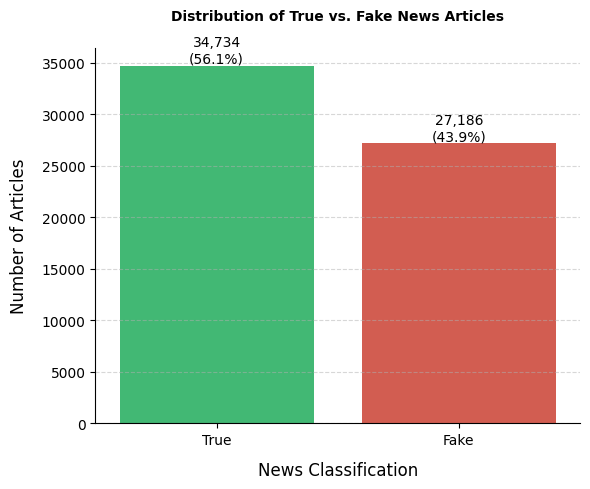

True News: 0.56
Fake News: 0.44


In [12]:
plot_news_distribution(df)

### News processing

In [13]:
from Preprocessing.TextPreprocessor import TextPreprocessor

preprocessor = TextPreprocessor()

tqdm.pandas(desc="Processing Text")
df["full_text_processed"] = df["full_text"].progress_apply(preprocessor.preprocess_text)
df = df.dropna(subset=['full_text_processed'])

Processing Text: 100%|██████████| 61920/61920 [12:28<00:00, 82.74it/s] 


In [14]:
df.head(2)

id                                              title  \
0   0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1   2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   

                                                text  label  \
0  No comment is expected from Barack Obama Membe...    1.0   
1   Now, most of the demonstrators gathered last ...    1.0   

                                           full_text  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   

                                 full_text_processed  
0  law enforcement high alert follow threat cop w...  
1  unbelievable obamas attorney general say charl...

In [15]:
empty_title_count = df['title'].str.strip().eq('').sum()
empty_text_count = df['text'].str.strip().eq('').sum()
empty_full_text_processed_count = df['full_text_processed'].str.strip().eq('').sum()

print(f"Number of news articles with empty title: {empty_title_count}")
print(f"Number of news articles with empty text: {empty_text_count}")
print(f"Number of news articles with empty full_text_processed: {empty_full_text_processed_count}")

Number of news articles with empty title: 0
Number of news articles with empty text: 0
Number of news articles with empty full_text_processed: 0


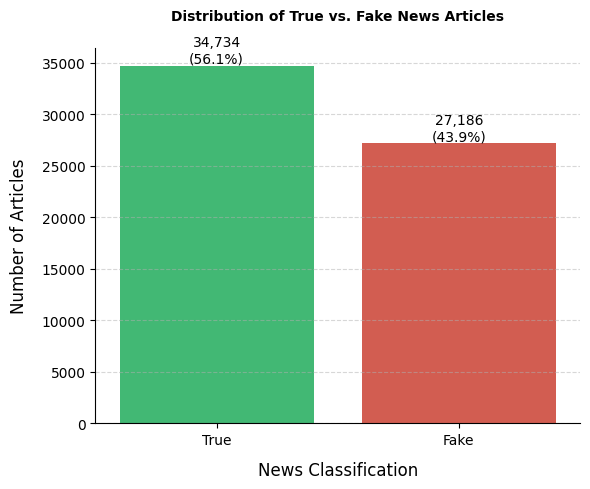

True News: 0.56
Fake News: 0.44


In [17]:
plot_news_distribution(df)

In [18]:
df.head(2)

id                                              title  \
0   0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1   2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   

                                                text  label  \
0  No comment is expected from Barack Obama Membe...    1.0   
1   Now, most of the demonstrators gathered last ...    1.0   

                                           full_text  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   

                                 full_text_processed  
0  law enforcement high alert follow threat cop w...  
1  unbelievable obamas attorney general say charl...

In [19]:
df.to_csv('WELFake_Dataset_processed.tsv', sep='\t', index=False)

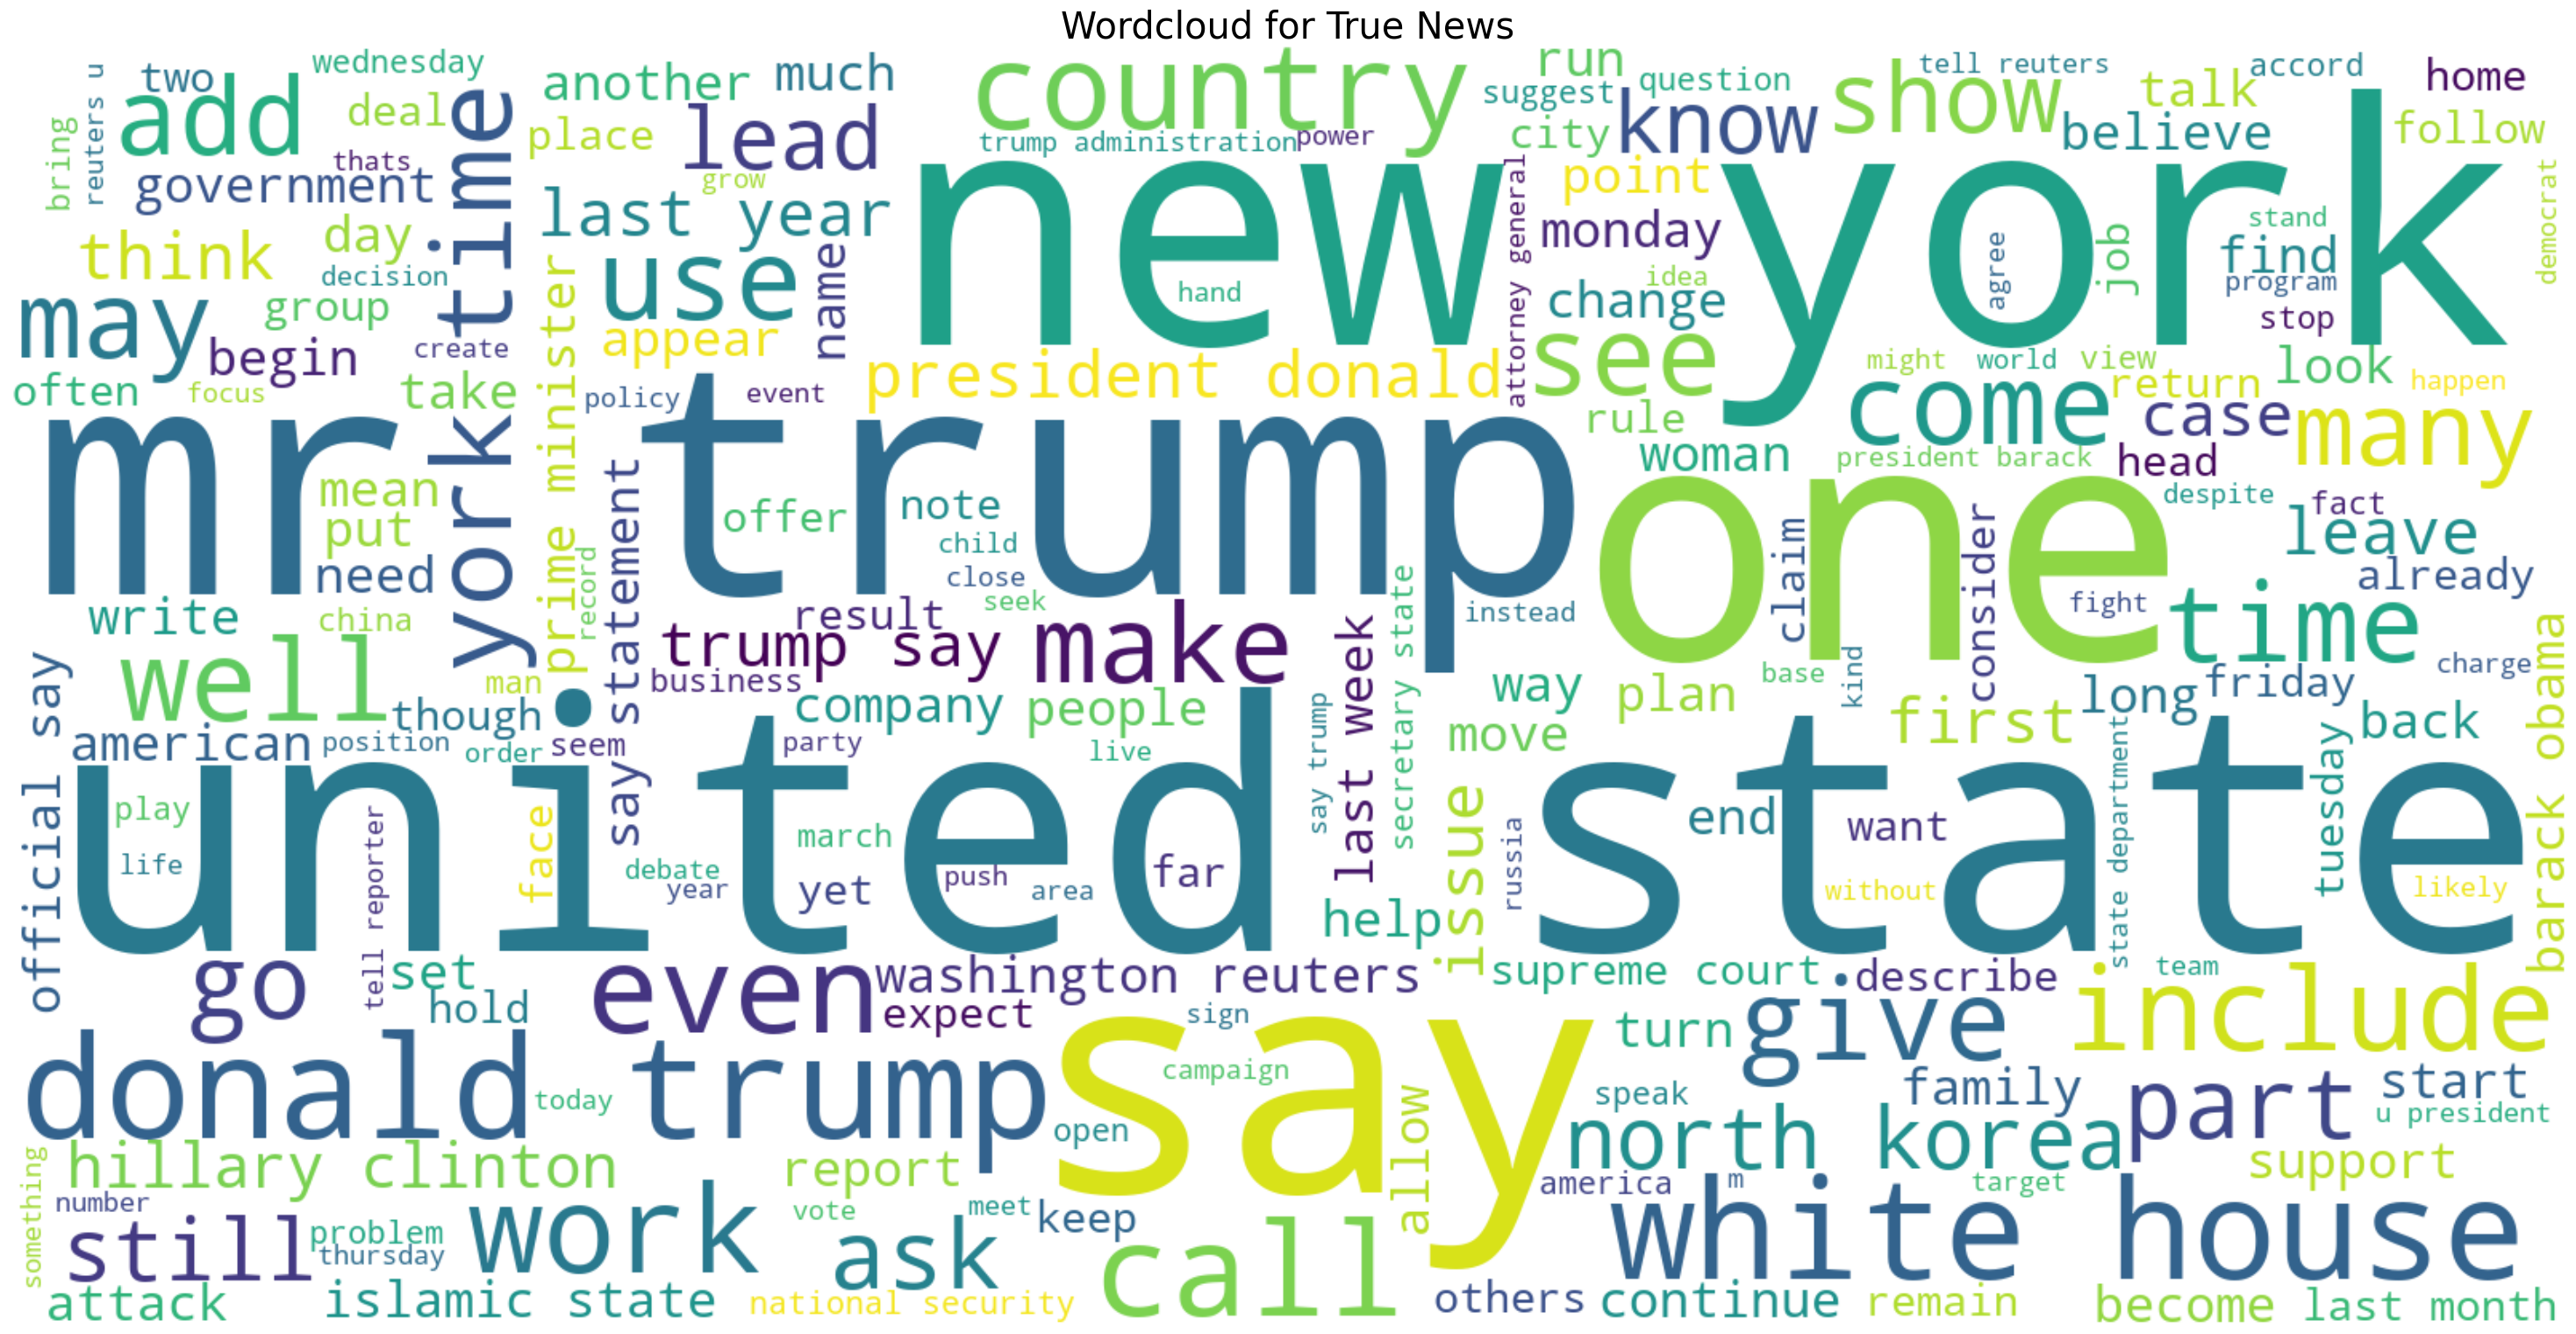

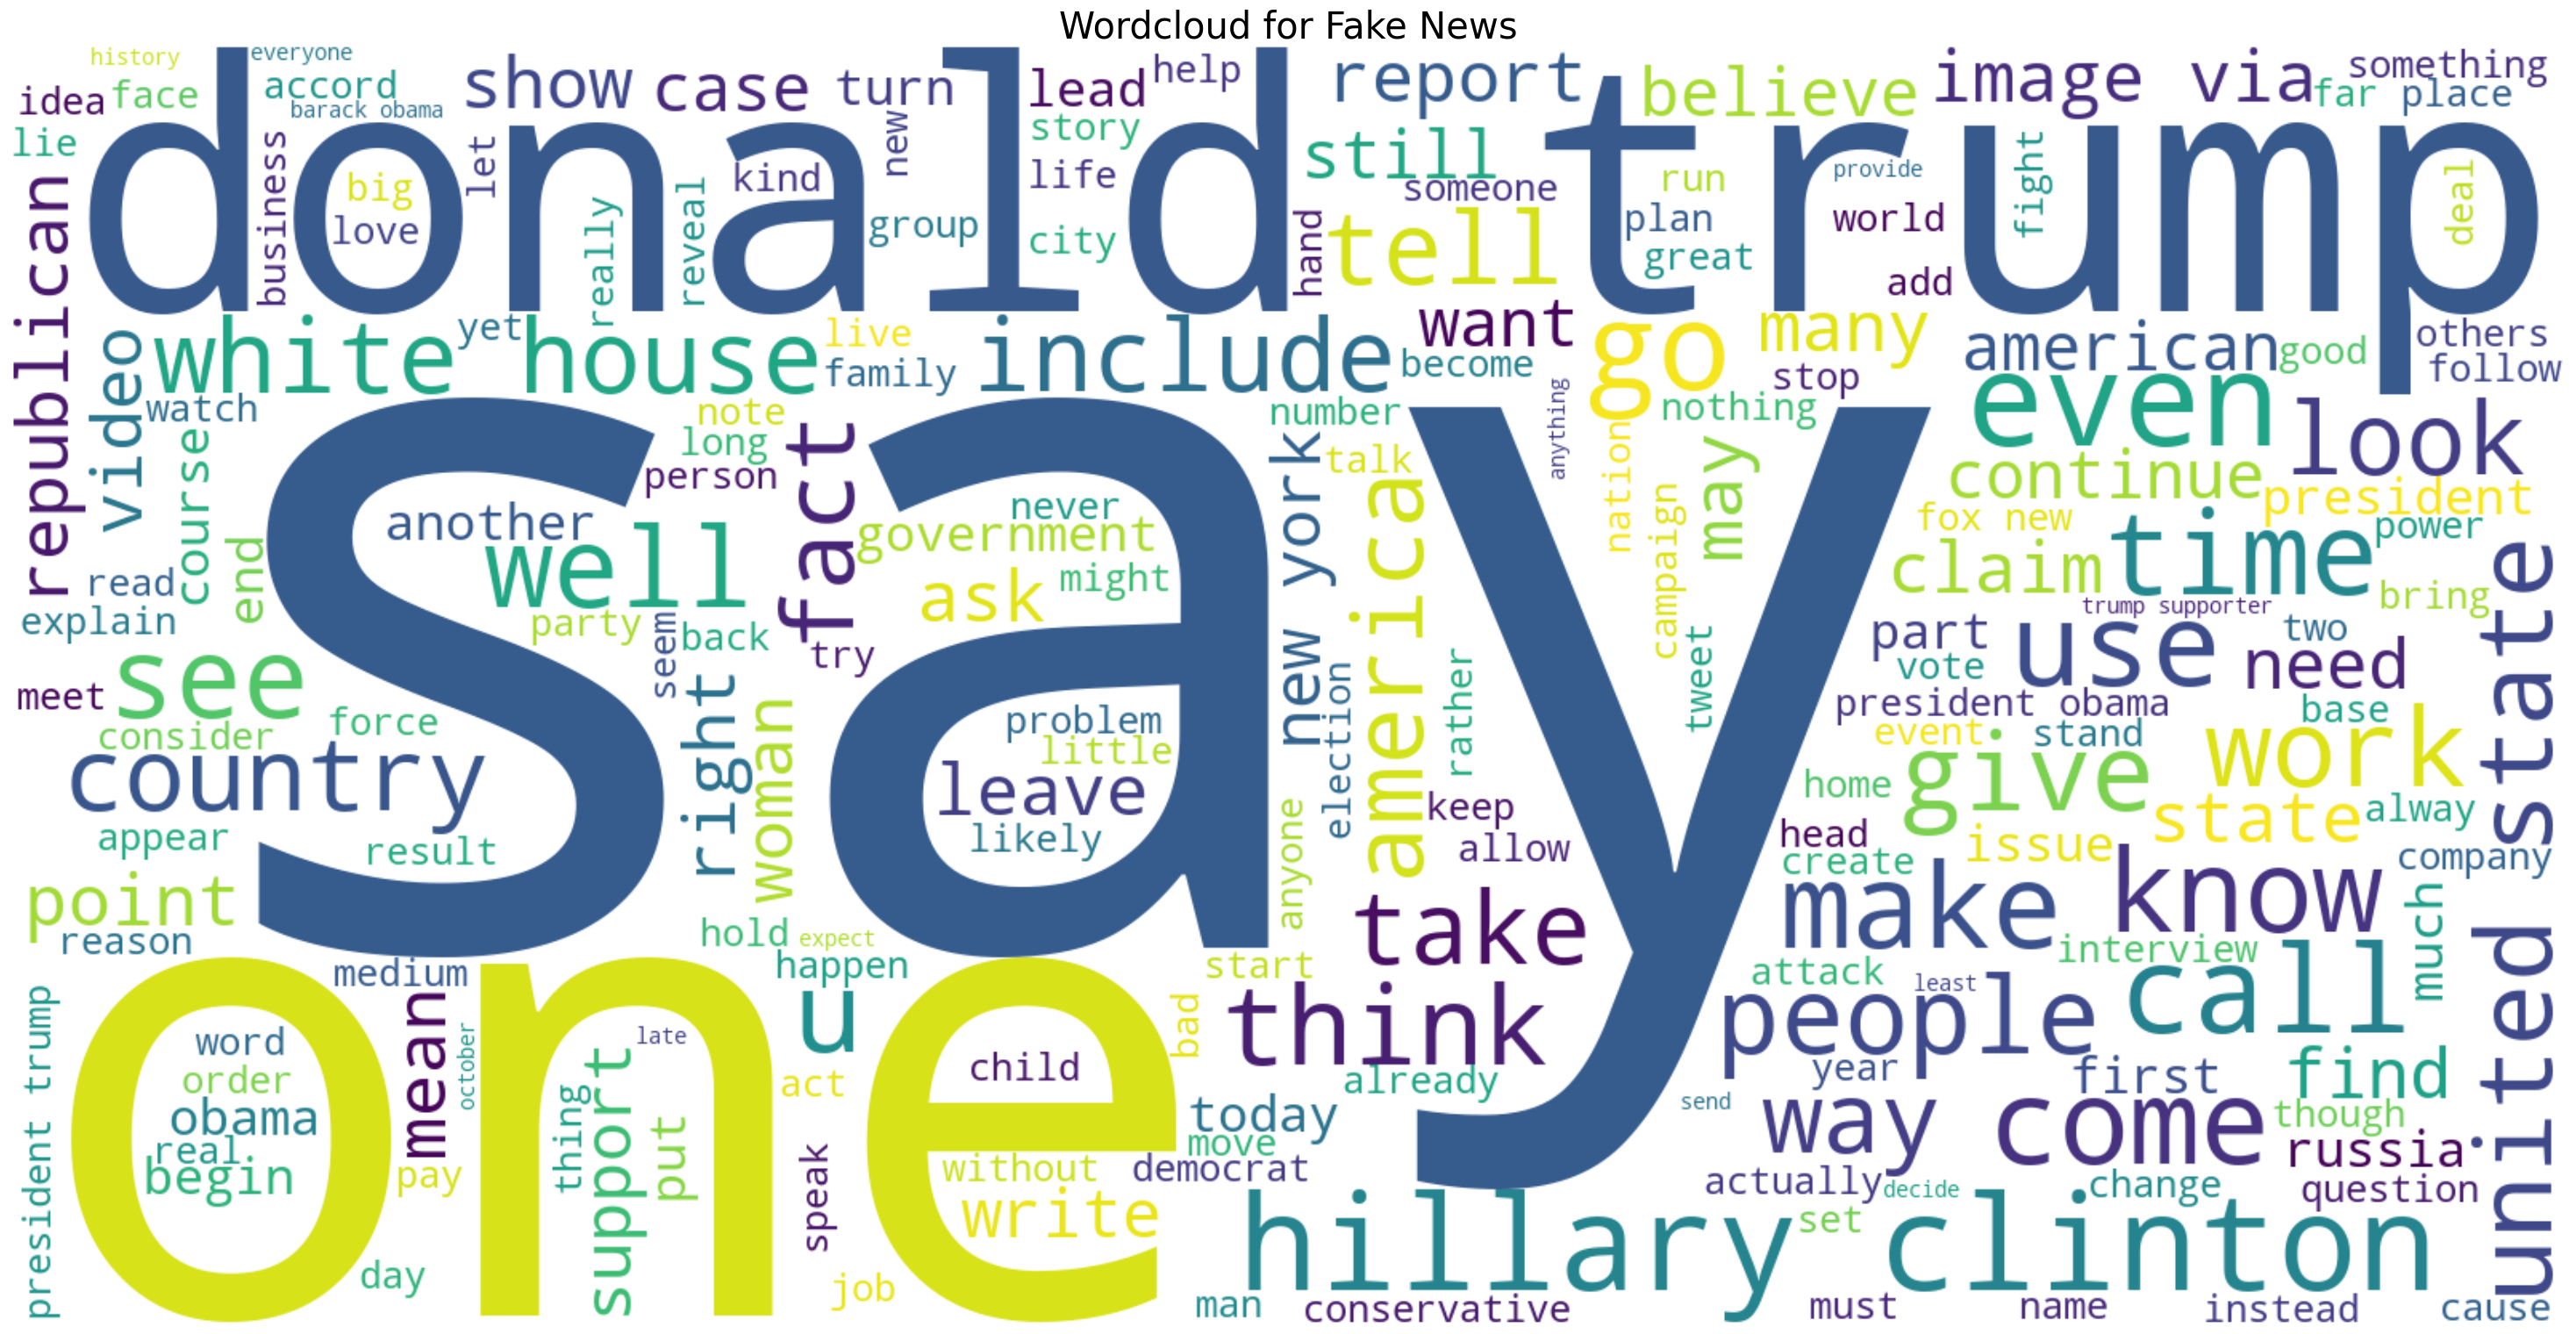

In [20]:
# Generate wordclouds for true and fake news
true_news_text = ' '.join(df[df['label'] == 0.0]['full_text_processed'])
fake_news_text = ' '.join(df[df['label'] == 1.0]['full_text_processed'])

# Create wordcloud for true news
wordcloud_true = WordCloud(
	width=1600,
	height=800, 
	background_color='white'
	).generate(true_news_text)
plt.figure(figsize=(30, 15))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.title('Wordcloud for True News', fontsize = 30)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Create wordcloud for fake news
wordcloud_false = WordCloud(
	width=1600,
	height=800, 
	background_color='white'
	).generate(fake_news_text)
plt.figure(figsize=(30, 15))
plt.imshow(wordcloud_false, interpolation='bilinear')
plt.title('Wordcloud for Fake News', fontsize = 30)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()